In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# Do not show warning in the output
import warnings
warnings.filterwarnings('ignore')

# display all outputs without having to inclue a print statement
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# make screen wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [5]:
def count_histogram(df, bins=16, save=False):
    
    x_label = '$M_{\star} [\log(M_{\u2609})]$'
    y_label = 'Number of halos'
    
    h = 0.6774
    lower_bound = 6.0
    upper_bound = 8.3
    narrowing_factor = 4.5 # For setting the bar width in the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15

    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    log_masses_z6 = np.log10(df_z6['StarMass'])
    log_masses_z8 = np.log10(df_z8['StarMass'])
    log_masses_z10 = np.log10(df_z10['StarMass'])

    edges = np.linspace(lower_bound, upper_bound, bins)
    binning_width = edges[1]-edges[0]
    bar_width = binning_width/narrowing_factor

    _ = plt.hist(log_masses_z6, bins=edges-bar_width, width = bar_width, label='z=6')
    _ = plt.hist(log_masses_z8+bar_width, bins=edges, width = bar_width, label='z=8')
    _ = plt.hist(log_masses_z10+2*bar_width, bins=edges+bar_width, width = bar_width, label='z=10')
    
    #plt.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/halo_counts.pdf', bbox_inches = 'tight')
    return

In [6]:
def plot_scatter(df, save=False):
    
    x_label = '$M_{\star}[\log(M_{\u2609})]$'
    y_label = '$\log(Q_{0})[\mathrm{s}^{-1}]$'
    
    h = 0.6774
    lower_bound = 5.7
    upper_bound = 9.3
    narrowing_factor = 4.5 # For setting the bar width in the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15

    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    _ = plt.scatter(np.log10(df_z6['StarMass']), np.log10(df_z6['Q0']), label='z=6')
    _ = plt.scatter(np.log10(df_z8['StarMass']), np.log10(df_z8['Q0']), label='z=8')
    _ = plt.scatter(np.log10(df_z10['StarMass']), np.log10(df_z10['Q0']), label='z=10')

    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf', bbox_inches = 'tight')
    return

In [7]:
def update_df(df):
    h = 0.6774
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [8]:
df = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

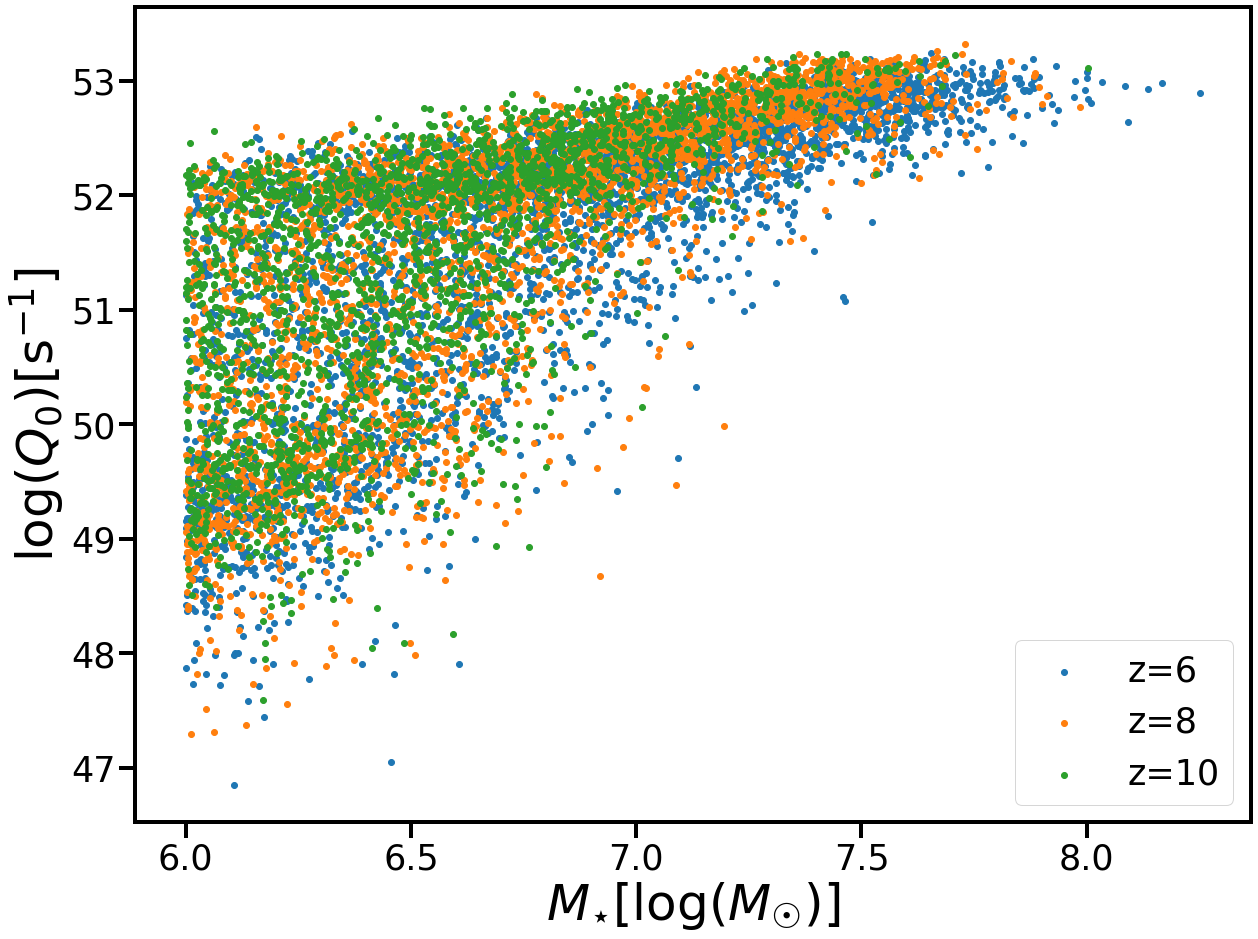

In [15]:
plot_scatter(df, save=True)

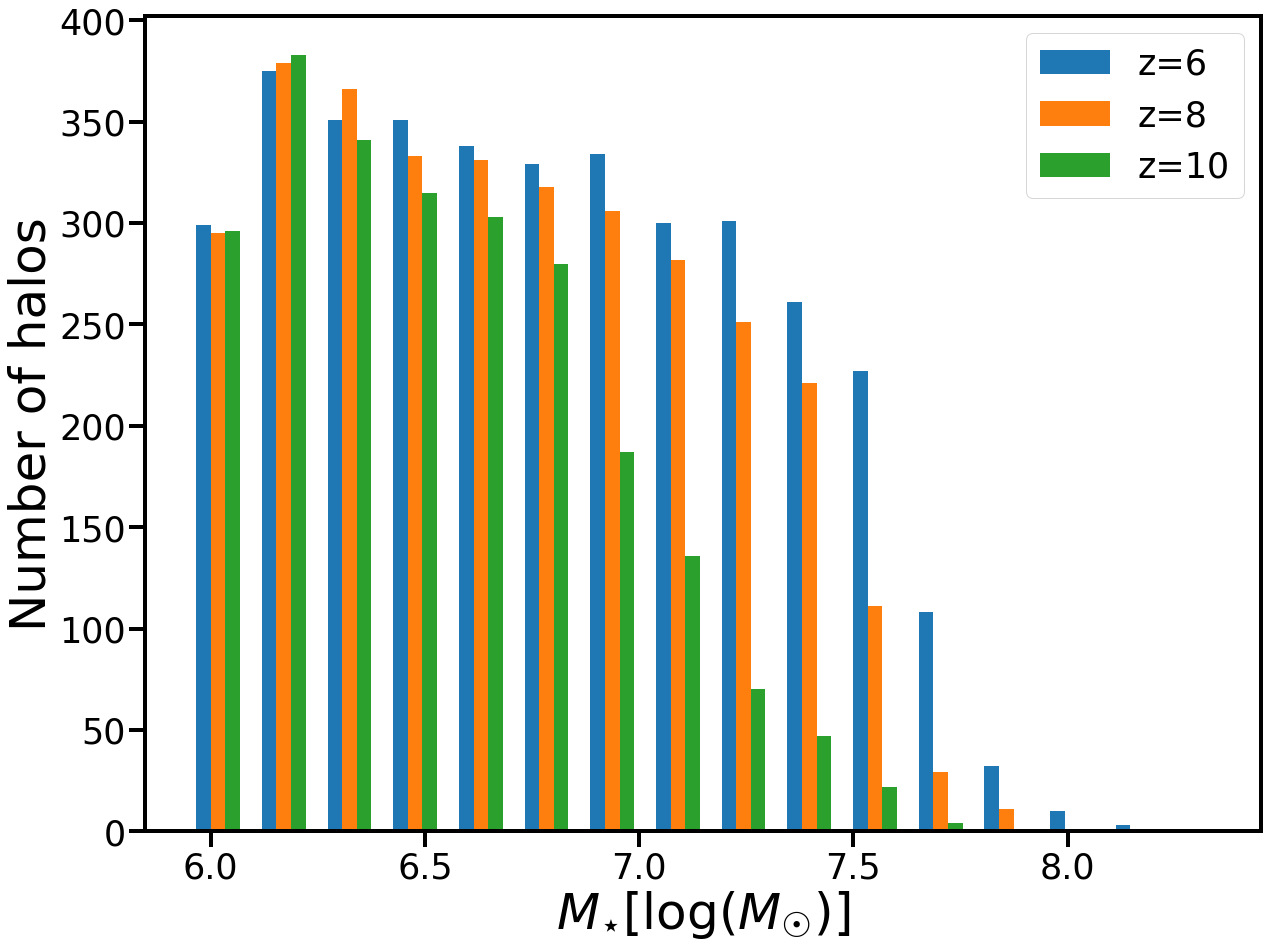

In [17]:
count_histogram(df, save=True)